<a href="https://colab.research.google.com/github/mohsenperfection/ML/blob/CHW03/Q1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 align="center">Introduction to Machine Learning - Course Code: 25737</h1>
<h4 align="center">Instructor: Dr. Amiri</h4>
<h4 align="center">Sharif University of Technology, Spring 2024</h4>
<h4 align="center">Computer Assignment 3</h4>
<h4 align="center">

Question 1

</h4>

# Personal Data

In [ ]:
# Set your student number
student_number = 99102083
Name = 'Mohsen'
Last_Name = 'Kamalabadi Farahani'

# Rules
- You are not allowed to add or remove cells. You **must use the provided space to write your code**. If you don't follow this rule, **your Practical Assignment won't be graded**.  

- Collaboration and using the internet is allowed, but your code **must be written by yourself**. **Copying code** from each other or from available resources will result in a **zero score for the assignment**.

- You are not allowed to use `torch.nn`, `torch.optim` and any activation function and loss function implemented in torch.

In [ ]:
!pip install numpy
!pip install matplotlib
!pip install torchvision
!pip install torch

## Importing Libraries

In [ ]:
import torch
from torchvision.datasets import FashionMNIST
from torchvision import transforms
from torch.utils.data import DataLoader

import numpy as np
from matplotlib import pyplot as plt
from typing import Dict

## Datasets and Dataloaders

Here, we download and load the train and test `FashionMNIST` dataset with the desired transforms. Then, we define the dataloaders for `train` and `test`.

In [ ]:
train_set = FashionMNIST(root='.', train=True, download=True, transform=transforms.ToTensor())
test_set = FashionMNIST(root='.', train=False, download=True, transform=transforms.ToTensor())


Here you have to calculate the number of classes amd input dimention of the first layer (how many pixels does each image have?).

In [ ]:
## FILL HERE
# input_dim = .....
# Calculate the number of classes
num_classes = len(train_set.classes)

# Input dimension
input_dim = train_set[0][0].numel()

print(f"Number of classes: {num_classes}")
print(f"Input dimension: {input_dim}")

Number of classes: 10
Input dimension: 784


In [ ]:
train_loader = DataLoader(train_set, 64, shuffle=True)
test_loader = DataLoader(test_set, 64, shuffle=True)

## Visualization

Visualize 1 random image from each class by using `plt.subplots`

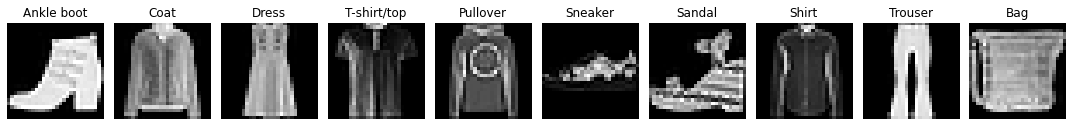

In [ ]:
class_images = {}

# Iterate through the train_loader to find one image per class
for images, labels in train_loader:
    for i in range(images.size(0)):
        label = labels[i].item()
        if label not in class_images:
            class_images[label] = images[i]
        if len(class_images) == num_classes:
            break
    if len(class_images) == num_classes:
        break

# Create a subplot for visualizing the images
fig, axes = plt.subplots(1, num_classes, figsize=(15, 15))

# Class labels for FashionMNIST
class_labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Plot each image
for i, (label, image) in enumerate(class_images.items()):
    ax = axes[i]
    ax.imshow(image.squeeze(), cmap='gray')
    ax.set_title(class_labels[label])
    ax.axis('off')

plt.tight_layout()
plt.show()

## Initializing model's parameters

In this part, we create the model and initialize its parameters and store the values of these parameters in the variable `parameters` which is a dictionary including the weigths and biases of each layer.

In [ ]:
def add_linear_layer(parameters: dict, shape, device, i=None):
    """
    This function adds parameters of a linear unit of shape `shape` to the `parameters` dictionary.
    """
    n_in, n_out = shape
    with torch.no_grad():
        w = torch.zeros(*shape, device=device)
        # kaiming initialization for ReLU activations:
        bound = 1 / np.sqrt(n_in).item()
        w.uniform_(-bound, bound)
        b = torch.zeros(n_out, device=device)  # no need to (1, n_out). it will broadcast itself.
    w.requires_grad = True
    b.requires_grad = True
    # `i` is used to give numbers to parameter names
    parameters.update({f'w{i}': w, f'b{i}': b})

Now we define our neural network with the given layers and add the weights and biases to the dictionary `parameters`. **You are allowed to modify the values of the layers**.

In [ ]:
# input_dim : input dimention of the first layer, which you have calculated before.
layers = [
    (input_dim, 512),
    (512, 256),
    (256, 128),
    (128, 64),
    (64, num_classes)
]
num_layers = len(layers)
parameters = {}

# setting the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# adding the parameters to the dictionary
for i, shape in enumerate(layers):
    add_linear_layer(parameters, shape, device, i)

parameters.keys()

dict_keys(['w0', 'b0', 'w1', 'b1', 'w2', 'b2', 'w3', 'b3', 'w4', 'b4'])

## Defining the required functions

In this section, we should define the required functions. For each of these functions, the inputs and the desired outputs are given and you should write all or part of the function. **You are not allowed to use the activation functions and the loss functions implemented in torch**.

Computing affine and relu outputs:

In [ ]:
def affine_forward(x, w, b):
    """
    Computes the affine transformation (Wx + b).
    x: input tensor of shape (N, d_in)
    w: weights tensor of shape (d_in, d_out)
    b: bias tensor of shape (d_out)
    """
    return x @ w + b

def relu(x):
    """
    Applies the ReLU activation function element-wise.
    x: input tensor
    """
    return torch.maximum(x, torch.zeros_like(x))

Function `model` returns output of the whole model for the input `x` using the parameters:

In [ ]:
def model(x: torch.Tensor, parameters, num_layers=num_layers):
    # number of batches
    B = x.shape[0]
    x = x.view(B, -1)  # Flatten the input

    # Iterate through each layer
    for i in range(num_layers):
        # Get the parameters for the current layer
        w = parameters[f'w{i}']
        b = parameters[f'b{i}']

        # Apply affine transformation
        x = affine_forward(x, w, b)

        # Apply ReLU activation if it's not the last layer
        if i < num_layers - 1:
            x = relu(x)

    # The final output of the model
    output = x
    return output


Implementing cross entropy loss:

In [ ]:
def cross_entropy_loss(scores, y):
    """
    Computes the cross entropy loss.

    scores: Tensor of shape (N, C) where N is the batch size and C is the number of classes.
    y: Tensor of shape (N,) where each value is the true class label for each sample.

    Returns:
    loss: Scalar tensor representing the average cross entropy loss over the batch.
    """
    n = len(y)

    # Compute the softmax probabilities
    exp_scores = torch.exp(scores)
    probabilities = exp_scores / torch.sum(exp_scores, dim=1, keepdim=True)

    # Compute the log probabilities
    log_probabilities = torch.log(probabilities)

    # Gather the log probabilities of the correct classes
    correct_log_probabilities = log_probabilities[range(n), y]

    # Compute the cross entropy loss
    loss = -torch.mean(correct_log_probabilities)

    return loss


Implementing a function for optimizing paramters and a function to zeroing out their gradients:

In [ ]:
def sgd_optimizer(parameters: Dict[str, torch.Tensor], learning_rate=0.001):
    '''This function gets the parameters and a learning rate. Then updates the parameters using their
    gradient. Finally, you should zero the gradients of the parameters after updating
    the parameter value.'''
    ## FILL HERE
    for param in parameters.values():
        if param.requires_grad:
            # Update parameter using its gradient
            param.data -= learning_rate * param.grad

            # Zero the gradient
            param.grad.zero_()

# Example usage
# Assuming `parameters` contains the model's parameters and they have been through a backward pass
# Create some dummy data to simulate gradients
for param in parameters.values():
    param.grad = torch.randn_like(param)  # Simulate some gradients

# Run the SGD optimizer
sgd_optimizer(parameters, learning_rate=0.01)

# Print updated parameters to see changes
for key, param in parameters.items():
    print(f"{key}: {param.data[:5]}")  # Print first 5 elements of each parameter tensor to check updates

w0: tensor([[ 0.0225,  0.0388,  0.0159,  ..., -0.0044,  0.0185, -0.0120],
        [ 0.0101, -0.0130, -0.0118,  ..., -0.0014,  0.0292,  0.0132],
        [ 0.0427, -0.0232, -0.0325,  ..., -0.0144,  0.0271, -0.0336],
        [ 0.0179, -0.0163,  0.0100,  ...,  0.0354, -0.0348,  0.0060],
        [ 0.0378, -0.0134,  0.0274,  ..., -0.0111, -0.0148,  0.0018]])
b0: tensor([ 0.0150, -0.0231,  0.0010,  0.0067, -0.0054])
w1: tensor([[ 0.0408, -0.0298, -0.0243,  ...,  0.0234, -0.0433,  0.0371],
        [-0.0405, -0.0024, -0.0340,  ...,  0.0468, -0.0005,  0.0201],
        [-0.0008,  0.0433, -0.0071,  ...,  0.0314, -0.0205, -0.0156],
        [ 0.0043, -0.0359,  0.0151,  ..., -0.0258,  0.0290, -0.0271],
        [ 0.0273,  0.0061,  0.0208,  ..., -0.0175,  0.0284,  0.0034]])
b1: tensor([-0.0314,  0.0025,  0.0114, -0.0133,  0.0017])
w2: tensor([[-2.8407e-02,  1.3652e-02, -1.4689e-02, -3.9676e-02, -3.6970e-03,
          4.6598e-03, -7.5488e-02,  3.2247e-02, -1.7365e-02, -6.5694e-03,
         -1.8595e-02, 

Training functions:

In [ ]:
def accuracy(y_pred: np.ndarray, y_true: np.ndarray):
    ## FILL HERE
    correct_predictions = np.sum(y_pred == y_true)
    total_predictions = len(y_true)
    acc = correct_predictions / total_predictions
    return acc

def train(train_loader, learning_rate=0.001, epoch=None):
    '''This function implements the training loop for a single epoch. For each batch you should do the following:
        1- Calculate the output of the model to the given input batch
        2- Calculate the loss based on the model output
        3- Update the gradients using backward method
        4- Optimize the model parameters using the sgd_optimizer function defined previously
        5- Print the train loss (Show the epoch and batch as well)
        '''
    train_loss = 0
    N_train = len(train_loader.dataset)

    # Creating empty lists Y and Y_pred to store the labels and predictions of each batch
    # for calculating the accuracy later
    Y = []
    Y_pred = []

    for i, (x, y) in enumerate(train_loader):
        x = x.to(device)
        y = y.to(device)

        # 1- Calculate the output of the model to the given input batch
        p = model(x, parameters)

        # 2- Calculate the loss based on the model output
        loss = cross_entropy_loss(p, y)
        train_loss += loss.item()

        # 3- Update the gradients using backward method
        loss.backward()

        # 4- Optimize the model parameters using the sgd_optimizer function defined previously
        sgd_optimizer(parameters, learning_rate)

        # 5- Print the train loss (Show the epoch and batch as well)
        if (i + 1) % 10 == 0 or (i + 1) == len(train_loader):
            print(f'Epoch [{epoch}], Batch [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

        y_pred = p.argmax(dim=-1)
        Y.append(y.cpu().numpy())
        Y_pred.append(y_pred.cpu().numpy())

    Y = np.concatenate(Y)
    Y_pred = np.concatenate(Y_pred)
    acc = accuracy(Y_pred, Y)
    train_loss /= len(train_loader)  # Average loss over the epoch
    print(f'Accuracy of train set: {acc * 100:.2f}%')
    return train_loss, acc


def validate(loader, epoch=None, set_name=None):
    '''This function validates the model on the test dataloader. The function goes through each batch and does
    the following on each batch:
        1- Calculate the model output
        2- Calculate the loss using the model output
        3- Print the loss for each batch and epoch

    Finally, the function calculates the model accuracy.'''
    total_loss = 0
    N = len(loader.dataset)

    # Creating empty lists Y and Y_pred to store the labels and predictions of each batch
    # for calculating the accuracy later
    Y = []
    Y_pred = []

    for i, (x, y) in enumerate(loader):
        x = x.to(device)
        y = y.to(device)

        # 1- Calculate the model output
        p = model(x, parameters)

        # 2- Calculate the loss using the model output
        loss = cross_entropy_loss(p, y)
        total_loss += loss.item()

        # 3- Print the loss for each batch and epoch
        print(f'Epoch [{epoch}], Batch [{i+1}/{len(loader)}], {set_name} Loss: {loss.item():.4f}')

        y_pred = p.argmax(dim=-1)
        Y.append(y.cpu().numpy())
        Y_pred.append(y_pred.cpu().numpy())

    # Concatenate the lists of labels and predictions
    Y = np.concatenate(Y)
    Y_pred = np.concatenate(Y_pred)

    # Calculate the accuracy
    acc = accuracy(Y_pred, Y)

    # Average loss over all batches
    total_loss /= len(loader)

    # Print the accuracy
    print(f'Accuracy of {set_name} set: {acc * 100:.2f}%')

    return total_loss, acc

In [ ]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [ ]:
def train_model(dataloaders, num_epochs, learning_rate=0.001, model_name='pytorch_model'):
    '''This function trains the model for the number of epochs given and stores, calculates and prints the train
    and test losses and accuracies. Finally, it plots the accuracy and loss history for training and test sets'''
    train_loader, test_loader = dataloaders

    for epoch in range(num_epochs):
        # Training phase
        train_loss, train_acc = train(train_loader, learning_rate, epoch)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # Validation phase
        test_loss, test_acc = validate(test_loader, epoch, set_name='test')
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)

        print(f'Epoch [{epoch+1}/{num_epochs}] - '
              f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc*100:.2f}% - '
              f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc*100:.2f}%')

    # Plot the loss history of training and test sets
    plt.figure(figsize=(12, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss History')
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, num_epochs + 1), test_accuracies, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy History')
    plt.legend()

    plt.tight_layout()
    plt.show()

Epoch [0], Batch [10/938], Loss: 2.2782
Epoch [0], Batch [20/938], Loss: 2.2754
Epoch [0], Batch [30/938], Loss: 2.2780
Epoch [0], Batch [40/938], Loss: 2.2761
Epoch [0], Batch [50/938], Loss: 2.2701
Epoch [0], Batch [60/938], Loss: 2.2751
Epoch [0], Batch [70/938], Loss: 2.2719
Epoch [0], Batch [80/938], Loss: 2.2713
Epoch [0], Batch [90/938], Loss: 2.2690
Epoch [0], Batch [100/938], Loss: 2.2701
Epoch [0], Batch [110/938], Loss: 2.2734
Epoch [0], Batch [120/938], Loss: 2.2646
Epoch [0], Batch [130/938], Loss: 2.2652
Epoch [0], Batch [140/938], Loss: 2.2633
Epoch [0], Batch [150/938], Loss: 2.2736
Epoch [0], Batch [160/938], Loss: 2.2616
Epoch [0], Batch [170/938], Loss: 2.2556
Epoch [0], Batch [180/938], Loss: 2.2505
Epoch [0], Batch [190/938], Loss: 2.2562
Epoch [0], Batch [200/938], Loss: 2.2533
Epoch [0], Batch [210/938], Loss: 2.2676
Epoch [0], Batch [220/938], Loss: 2.2566
Epoch [0], Batch [230/938], Loss: 2.2556
Epoch [0], Batch [240/938], Loss: 2.2490
Epoch [0], Batch [250/938

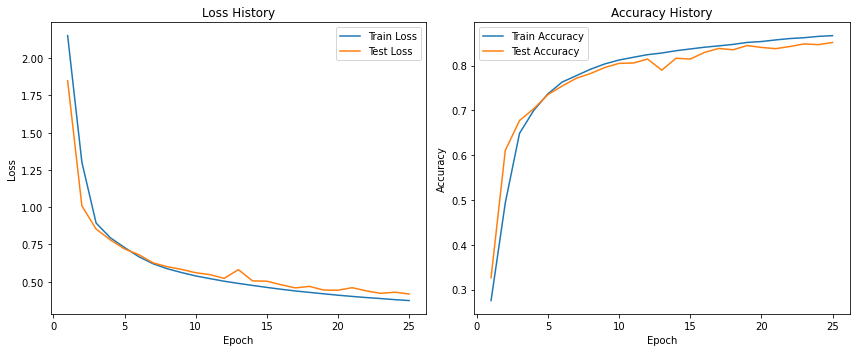

In [ ]:
train_model([train_loader, test_loader], num_epochs=25, learning_rate=0.005)

In [ ]:
print(f'Final test accuracy: {test_accuracies[-1]}')

Final test accuracy: 0.8518


## Visualization of the labels and predictions

In this section, you should visual one image from each class and show both the actual label and the predicted label for that image.

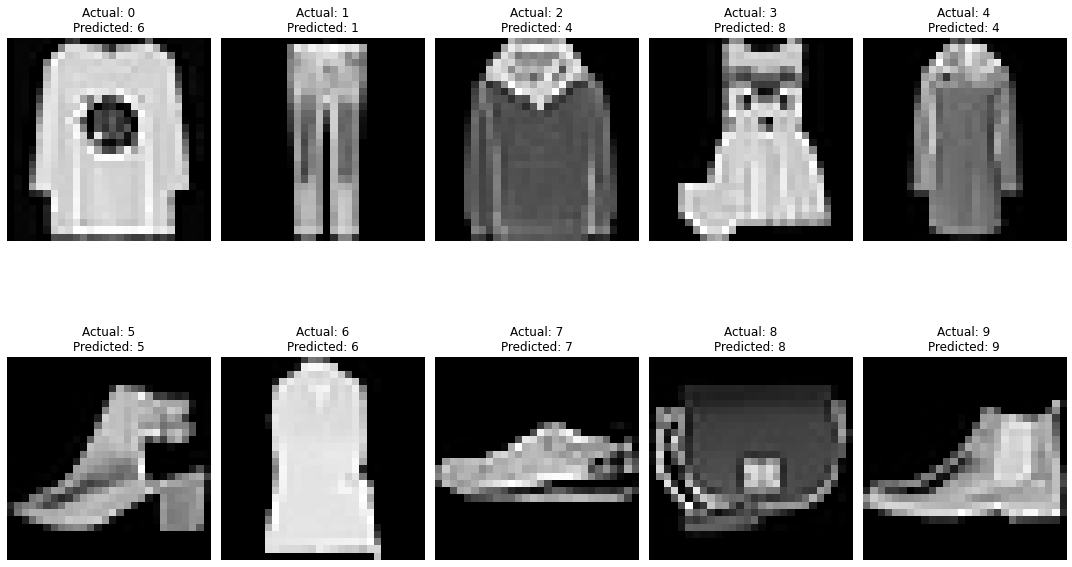

In [ ]:
import matplotlib.pyplot as plt

def visualize_predictions(model, dataloader, parameters):
    """
    Visualizes one image from each class along with the actual and predicted labels.
    """
    # Initialize a dictionary to store one image per class
    class_images = {}

    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            y = y.to(device)

            # Get model predictions
            outputs = model(x, parameters)
            _, preds = torch.max(outputs, 1)

            # Store one image per class
            for img, label, pred in zip(x, y, preds):
                if label.item() not in class_images:
                    class_images[label.item()] = (img, pred.item())
                # Break the loop if we have one image for each class
                if len(class_images) == 10:
                    break

    # Plotting the images
    plt.figure(figsize=(15, 10))
    for i in range(10):
        img, pred = class_images[i]
        img = img.cpu().numpy().squeeze()  # Move to CPU and remove the channel dimension
        actual_label = i
        predicted_label = pred

        plt.subplot(2, 5, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f"Actual: {actual_label}\nPredicted: {predicted_label}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Example usage
# Assuming test_loader is defined and parameters are initialized
visualize_predictions(model, test_loader, parameters)
